In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [2]:
tf.__version__
batch_size = 32
img_height = 180
img_width = 180

In [3]:
train_dir = r'C:\Users\69037\Desktop\CamAI\Final\train'
data_dir = pathlib.Path(train_dir)

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['cat', 'dog']


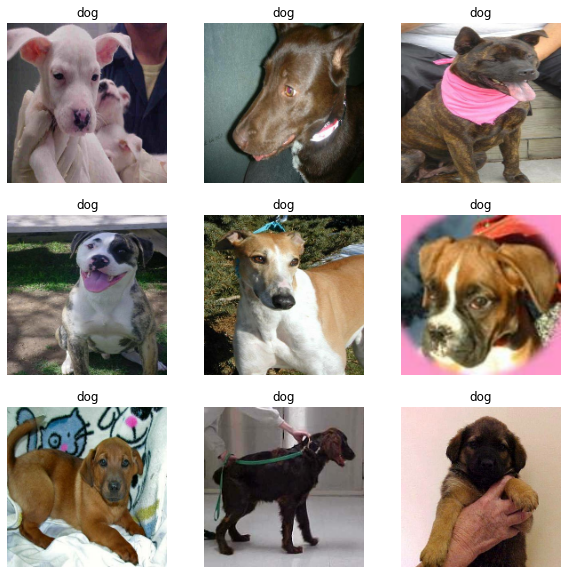

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
      print(image_batch.shape)
      print(labels_batch.shape)
      break

(32, 180, 180, 3)
(32,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0029829466 0.9806476


In [12]:
labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0])>

In [13]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),  
  layers.Dense(128, activation='relu'), 
    layers.Dense(num_classes)
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
flatten (Flatten)            (None, 97200)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               12441728  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 41s 64ms/step - loss: 1.7660 - accuracy: 0.5329 - val_loss: 0.6827 - val_accuracy: 0.5606
Epoch 2/10
625/625 [==============================] - 31s 49ms/step - loss: 0.6943 - accuracy: 0.5520 - val_loss: 0.6923 - val_accuracy: 0.5622
Epoch 3/10
625/625 [==============================] - 31s 50ms/step - loss: 0.6889 - accuracy: 0.5278 - val_loss: 0.6753 - val_accuracy: 0.5748
Epoch 4/10
625/625 [==============================] - 30s 48ms/step - loss: 0.6843 - accuracy: 0.5508 - val_loss: 0.6762 - val_accuracy: 0.5766
Epoch 5/10
625/625 [==============================] - 31s 49ms/step - loss: 0.6796 - accuracy: 0.5611 - val_loss: 0.6742 - val_accuracy: 0.5848
Epoch 6/10
625/625 [==============================] - 31s 49ms/step - loss: 0.6775 - accuracy: 0.5693 - val_loss: 0.6897 - val_accuracy: 0.5296
Epoch 7/10
625/625 [==============================] - 31s 50ms/step - loss: 0.6810 - accuracy: 0.5602 - val_loss: 0.6781 - val_accuracy:

In [17]:
model.save(r'C:\Users\69037\Desktop\CamAI\Final\modelSaver')

INFO:tensorflow:Assets written to: C:\Users\69037\Desktop\CamAI\Final\modelSaver\assets


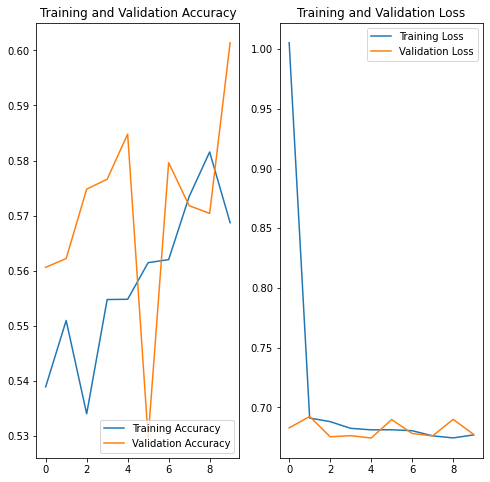

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This image most likely belongs to dog with a 50.01 percent confidence.


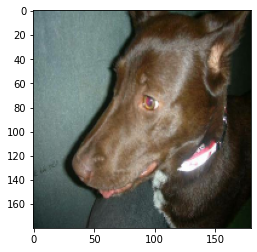

In [31]:
t = images[1]
plt.imshow(t.numpy().astype("uint8"))
t = tf.expand_dims(t,0)
predictions = model.predict(t)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [47]:

train_ds.enumerate
       

<bound method DatasetV2.enumerate of <BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>>

In [22]:
predictions

array([[-0.02164015, -0.02131206]], dtype=float32)

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)